In [14]:
import os
#os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from pyfesom2.ut import scalar_g2r, scalar_r2g
from pyfesom2 import load_mesh
import xarray as xr
import numpy as np
import shutil
import sys
import random
import string

from scipy.io import loadmat
from scipy.interpolate import griddata

sys.path.append("/p/home/jusers/mueller29/juwels/jupyter_notebooks/implicit_filtering/")
from implicit_filter import CuPyFilter
import math
import dask
from dask import delayed
import dask.array as da
from dask.distributed import Client
from dask.distributed import Lock
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})


In [4]:
ice_all=xr.open_mfdataset((data_path+'a_ice.fesom.'+str(year)+'.nc'),chunks={'time':time_chunk,'nod2':nod2_chunk})['a_ice'].astype('float32')

In [5]:
dd=0
ice_in = ice_all[dd,:]

In [40]:
##### define all the functions

def generate_random_string(length):
    # Define the characters to choose from
    characters = string.ascii_letters + string.digits  # You can add more characters if needed
    # Use random.choices to generate a list of random characters
    random_characters = random.choices(characters, k=length)
    # Join the characters into a string
    random_string = ''.join(random_characters)
    return random_string

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Distance in kilometers
    distance = R * c
    
    return distance

def get_dxdy(lon1, lon2, lat1, lat2):
    # Calculate distance and angle
    dist = haversine(lon1, lat1, lon2, lat2)
    ang = np.arctan2(lat2 - lat1,lon2 - lon1)
    
    # Calculate dx and dy
    dx = dist * np.cos(ang)
    dy = dist * np.sin(ang)
    
    return dx, dy

def get_points_within_radius(lon_in, lat_in, lon_target, lat_target, radius, fac):
    # Compute distances from all points to the target point
    distances = haversine(lon_in, lat_in, lon_target, lat_target)
    max_radius = radius*fac
    # Filter points within the maximum radius
    within_radius_indices = np.where(distances <= max_radius)[0]
    within_one_radius = np.where(distances <= radius)[0]
    within_radius_lon = lon_in[within_radius_indices]
    within_radius_lat = lat_in[within_radius_indices]
    
    dlon =  within_radius_lon - lon_target
    dlat =  within_radius_lat - lat_target

    # Calculate differences between target point and filtered points
    dx_km, dy_km = get_dxdy(lon_target, within_radius_lon, lat_target, within_radius_lat)

    dx_rel = dx_km/radius
    dy_rel = dy_km/radius
    return within_one_radius, within_radius_indices, dlon, dlat, dx_km, dy_km, dx_rel, dy_rel

def process_eddy(lon_target, lat_target, radius_target, lon_in, lat_in, data_in,ice_in, fac, X, Y):
    within_one_radius, within_radius_indices, _, _, _, _, dx_rel, dy_rel = get_points_within_radius(lon_in, lat_in, lon_target, lat_target, radius_target, fac)
    data_tmp = data_in[within_radius_indices]
    gridded_data = griddata((dx_rel.ravel(), dy_rel.ravel()), data_tmp.ravel(), (X, Y), method='linear', fill_value=np.nan)
    ice_avg = ice_in[within_one_radius].mean(dim='nod2').round(3).values
    del within_radius_indices
    del within_one_radius
    del data_in
    del data_tmp
    del dx_rel
    del dy_rel
    del X
    del Y
    return gridded_data, ice_avg

def create_empty_netcdf(outfile,date,var,ne,nx,ny):
    if (os.path.exists(outfile)):
        os.remove(outfile)    
    date_string = '-'.join([str(date.dt.year.values), '01', f'01'])
    
    tref = np.datetime64(date_string,'ns')    
    tnow = date.values
    time_values_seconds = (tnow-tref) / np.timedelta64(1, 's')
    
    # Create the dataset
    ds = xr.Dataset()
    # Assuming 'x' and 'y' are the dimensions of the slices
    ds[var] = xr.DataArray(np.empty((1,ne, nx, ny)), dims=['time','ee', 'x', 'y']) #the gridded field around eddy
    ds['cyc'] = xr.DataArray(np.empty((1,ne)), dims=['time','ee']) #sense of rotation
    ds['lon'] = xr.DataArray(np.empty((1,ne)), dims=['time','ee']) #center lon
    ds['lat'] = xr.DataArray(np.empty((1,ne)), dims=['time','ee']) #center lat
    ds['rad'] = xr.DataArray(np.empty((1,ne)), dims=['time','ee']) #radius
    ds['speed'] = xr.DataArray(np.empty((1,ne)), dims=['time','ee']) #rot. speed
    ds['ice_avg'] = xr.DataArray(np.empty((1,ne)), dims=['time','ee']) #average sea ice concentration
    ds['time'] = xr.DataArray([time_values_seconds], dims='time', attrs={'units': 'seconds since 2015-01-01 0:0:0'}) #the same for every eddy on that day, so can be set here
    ds['num'] =  xr.DataArray(np.empty((1,ne)), dims=['time','ee']) #running number per day -> 'ee'
    # Write the dataset to a NetCDF file with specified permissions
    ds.to_netcdf(outfile, mode='w', encoding={var: {'dtype': 'float32'}})        
        
    
@delayed
def process_date(lon_target, lat_target, type_target, radius_target, speed_target,lon_in, lat_in, data_in, ice_in, fac, X, Y, ind,var,outfile,lock):
    gridded_data,ice_avg = process_eddy(lon_target, lat_target, radius_target,lon_in, lat_in, data_in, ice_in, fac, X, Y)
    lon_target,lat_target = scalar_r2g(-90,90,90,np.array([lon_target]),np.array([lat_target])) #rotate eddy lon/lat to coordinates at pole
    with lock:    
        with xr.open_dataset(outfile, mode='a') as ds:
            ds[var][0, ind, : , :] = gridded_data
            ds['cyc'][0, ind] = type_target
            ds['lon'][0, ind] = lon_target[0]
            ds['lat'][0, ind] = lat_target[0]
            ds['rad'][0, ind] = radius_target
            ds['speed'][0, ind] = speed_target
            ds['ice_avg'][0, ind] = ice_avg
            ds['num'][0,ind] = ind
        ds.to_netcdf(outfile, mode='a', encoding={var: {'dtype': 'float32'}})


In [7]:
#spawn a parallel cluster
n_cores = 12
mem_lim = str(int(100*np.floor(1000/n_cores)))+'MB' #96GB total memory, set to MB (96000), divide by number of cores, then round to next 100
dask_dir = '/p/scratch/chhb19/mueller29/dask_dir/'+generate_random_string(10)
if os.path.exists(dask_dir):
    shutil.rmtree(dask_dir)
if 'client' in locals() or 'client' in globals():
    client.close()
client = Client(local_directory=dask_dir,n_workers=n_cores, threads_per_worker=1,memory_limit=mem_lim)
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/8787/status,
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 92.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41817,Workers: 12
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 92.76 GiB
Comm: tcp://127.0.0.1:41261,Total threads: 1
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/45639/status,Memory: 7.73 GiB
Nanny: tcp://127.0.0.1:39583,


In [8]:
%%time

#inputs
year=2015
var='temp_100'
#depth=int(sys.argv[3]) #which year from input
depth=100 #which year from input

time_chunk = 1; #chunk data saily -> each day is treated separately anyway
nod2_chunk = 11538465; #make sure no chunking in space!
fac=5 # factor of 5*eddy_radius around each eddy center point

# paths
data_path = '/p/scratch/chhb19/mueller29/AO_40_nopc/'
mesh_path = '/p/project/chhb19/meshes/AO_40/'

# load fesom mesh stuff
mesh=pf.load_mesh(mesh_path)
model_lons=mesh.x2
model_lats=mesh.y2
# rotate to equator (eddy detection stuff is saved in rotated coordinates)
lons_rot,lats_rot = pf.ut.scalar_g2r(-90,90,90,model_lons,model_lats)

lon_in_dask_array = da.from_array(lons_rot, chunks='auto')
#client.persist(lon_in_dask_array)
lat_in_dask_array = da.from_array(lats_rot, chunks='auto')
#client.persist(lat_in_dask_array)


# load eddy shapes from Nencioli detection
global all_days, all_lats, all_lons, all_rads, all_types, all_speeds  # Declare variables as global

mat_path = '/p/project/chhb19/mueller29/Nencioli_tracking/' + str(depth) + 'm/python_readable/'
vars = ['lons', 'lats', 'rads', 'speeds', 'types']

all_days = None  # Initialize all_days
all_lats = None  # Initialize all_lats
all_lons = None  # Initialize all_lons
all_rads = None  # Initialize all_rads
all_types = None  # Initialize all_types
all_speeds = None  # Initialize all_speeds

for mat_var in vars:
    try:
        mat = loadmat(mat_path + 'eddy_' + mat_var + '.mat')
        all_data = mat.get(mat_var)
        if all_data is not None:
            globals()['all_' + mat_var] = all_data.flatten()
            print(f"Loaded {mat_var} successfully.")
        else:
            print(f"Warning: Variable {mat_var} is not found in the loaded .mat file.")
    except Exception as e:
        print(f"Error loading {mat_var}:", e)

# Load 'eddy_days.mat'
try:
    mat = loadmat(mat_path + 'eddy_days.mat')
    all_days = mat['days']
    print("Loaded days successfully.")
except Exception as e:
    print("Error loading 'eddy_days.mat':", e)

# Now keep only eddies from the year to analyze (eddy data contains all years)
if all_lats is not None:  # Check if all_lats has been assigned a value
    ind_year = all_days[:, 0] == year
    all_days = all_days[ind_year]
    all_lats = all_lats[ind_year]
    all_lons = all_lons[ind_year]
    all_rads = all_rads[ind_year]
    all_types = all_types[ind_year]
    all_speeds = all_speeds[ind_year]
else:
    print("Error: all_lats has not been initialized.")

#load filter
jf = CuPyFilter.load_from_file('/p/home/jusers/mueller29/juwels/jupyter_notebooks/implicit_filtering/filter_cash_AO_1km.npz')
dxm = 1 # Approximate resolution of the mesh in km
Kc = np.array([100]) * dxm #!!!this might have to be adjusted!!! right now 100km filter (high-pass)
Kc = 2 * math.pi / Kc  # Wavenumbers
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180 

# load FESOM data
data_all=xr.open_mfdataset((data_path+var+'.fesom.'+str(year)+'.nc'),chunks={'time':time_chunk,'nod2':nod2_chunk})[var].astype('float32')
ice_all=xr.open_mfdataset((data_path+'a_ice.fesom.'+str(year)+'.nc'),chunks={'time':time_chunk,'nod2':nod2_chunk})['a_ice'].astype('float32')


#define regular mesh in multiples of R
reg_x = np.arange(-3.1,3.2,.1)
reg_y = np.arange(-3,3.1,.1)
X,Y = np.meshgrid(reg_x,reg_y)

nx = X.shape[0] #size of gridded data in x direction
ny = X.shape[1] #size of gridded data in y direction
ndays = len(all_days) #number of days 
out_path='/p/scratch/chhb19/mueller29/composites/100m/'+var+'/'
os.makedirs(out_path, exist_ok=True)

/p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
Loaded lons successfully.
Loaded lats successfully.
Loaded rads successfully.
Loaded speeds successfully.
Loaded types successfully.
Loaded days successfully.


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


CPU times: user 3.64 s, sys: 1.61 s, total: 5.25 s
Wall time: 4.77 s


In [41]:
%%time

dd=0
lons=all_lons[dd].flatten()
lats=all_lats[dd].flatten()   
#lons,lats = pf.ut.scalar_r2g(-90,90,90,lons,lats) #rotate eddy lon/lat to coordinates at pole
rads=all_rads[dd].flatten()
types=all_types[dd].flatten()
speeds=all_speeds[dd].flatten()
date=all_days[dd]

ok_size = rads > 1.5
ok_speed = speeds > 0

lons=lons[ok_size&ok_speed]
lats=lats[ok_size&ok_speed]
rads=rads[ok_size&ok_speed]
types=types[ok_size&ok_speed]
speeds=speeds[ok_size&ok_speed]   

ne = len(lons)

# # Zero-pad the month and day components
date_string = ''.join([str(date[0]), f'{date[1]:02}', f'{date[2]:02}'])
# # Convert to datetime object
# datetime_object = np.datetime64(date_string,'ns')
# date_string = np.datetime_as_string(datetime_object,unit='D').replace('-', '')

#load and high-pass filter data
data = data_all[dd,:].values
data_coarse = jf.compute(1, Kc[-1], data)
data_in = data-data_coarse
date_xr = data_all.time[dd]

ice_in = ice_all[dd,:]

filename = 'composite_'+var+'_'+date_string+'.nc'

#Create the empty Dataset
outfile = (out_path+filename)    
create_empty_netcdf(outfile, date_xr, var, ne, nx, ny)

#persist the input data
data_in_dask_array = da.from_array(data_in, chunks='auto')
#client.persist(data_in_dask_array)

#client.persist(ice_in)

# datetime_dask_array = da.from_array(datetime_object)
# client.persist(datetime_dask_array)

#make composites first lazy, then compute in parallel and save
results = []
lock = Lock()
ii=0

lon_eddy = lons[ii]
lat_eddy = lats[ii]
type_eddy = types[ii]
rad_eddy = rads[ii]
speed_eddy = speeds[ii]


lon_in = lon_in_dask_array
lat_in = lat_in_dask_array
lon_target = lon_eddy
lat_target = lat_eddy
radius_target = rad_eddy


CPU times: user 1.24 s, sys: 171 ms, total: 1.41 s
Wall time: 1.95 s


In [42]:
results = []
lock = Lock()
results.append(process_date(lon_eddy, lat_eddy, type_eddy, rad_eddy, speed_eddy, lon_in_dask_array, lat_in_dask_array, data_in_dask_array, ice_in, fac, X, Y, ii,var,outfile,lock))  

In [43]:
dask.compute(results)

([None],)

In [10]:
within_one_radius, within_radius_indices, _, _, _, _, dx_rel, dy_rel = get_points_within_radius(lon_in, lat_in, lon_target, lat_target, radius_target, fac)
data_tmp = data_in[within_radius_indices]
gridded_data = griddata((dx_rel.ravel(), dy_rel.ravel()), data_tmp.ravel(), (X, Y), method='linear', fill_value=np.nan)


/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 176.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 176.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [11]:
import matplotlib.pyplot as plt
import cmocean
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import  BoundaryNorm
from matplotlib import colormaps

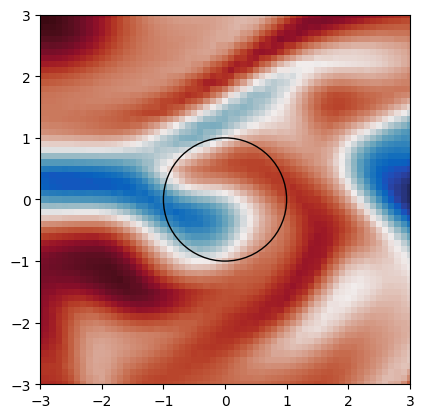

In [12]:
# Create a figure and axis
fig, ax = plt.subplots()

ax.pcolormesh(X,Y,gridded_data,cmap=cmocean.cm.balance)

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')
# Add the circle patch to the axis
ax.add_patch(circle)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# Show the plot
plt.show()

In [ ]:
lon1=0
lat1=0
lon2=0
lat2=1

# Calculate distance and angle
dist = haversine(lon1, lat1, lon2, lat2)
ang = np.arctan2(lat2 - lat1,lon2 - lon1)

# Calculate dx and dy
dx = dist * np.cos(ang)
dy = dist * np.sin(ang)

In [ ]:
dy

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

ax.pcolormesh(X,Y,gridded_data,cmap=cmocean.cm.balance)

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')
# Add the circle patch to the axis
ax.add_patch(circle)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# Show the plot
plt.show()

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

ax.pcolormesh(X,Y,gridded_data,cmap=cmocean.cm.balance)

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')
# Add the circle patch to the axis
ax.add_patch(circle)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# Show the plot
plt.show()